In [1]:
import numpy as np
import dask , dask.distributed
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import warnings
warnings.simplefilter('ignore')
import dask_jobqueue
from astropy.convolution import Box2DKernel, convolve
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator, LongitudeLocator)
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature

# plot and filter same sign regions

In [2]:
ds_corr=xr.load_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/3x3_boxfilter_ssh_correlations_monthly.nc')
ds_corr_sst=xr.load_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/BOX_filtered/3x3_boxfilter_sst_correlations_monthly.nc')

In [ ]:
def samesign(ds_corr, ds_corr_sst):
    ds_corr_xmean=ds.mean('xt_ocean')
    ds_corr_sst_xmean=ds_corr_sst.mean('xt_ocean')
    ###start with same sign and SSH: O2, CO2
    SSH_O2_DIC_p=ds_corr.corr_ssh_o2.where(ds_corr.corr_ssh_o2 >0).where(ds_corr.corr_ssh_dic >0)
    SSH_O2_DIC_n=ds_corr.corr_ssh_o2.where(ds_corr.corr_ssh_o2 <0).where(ds_corr.corr_ssh_dic <0)
    SSH_O2_DIC=SSH_O2_DIC_p.combine_first(SSH_O2_DIC_n)
    
    ###start with same sign and SSH: O2, SST
    SSH_SST_O2_p=ds_corr.corr_ssh_o2.where(ds_corr.corr_ssh_o2 >0).where(ds_corr.corr_ssh_sst >0)
    SSH_SST_O2_n=ds_corr.corr_ssh_o2.where(ds_corr.corr_ssh_o2 <0).where(ds_corr.corr_ssh_sst <0)
    SSH_SST_O2=SSH_SST_O2_p.combine_first(SSH_SST_O2_n)
    
    ###start with same sign and SSH: CO2, SST
    SSH_SST_DIC_p=ds_corr.corr_ssh_dic.where(ds_corr.corr_ssh_dic >0).where(ds_corr.corr_ssh_sst >0)
    SSH_SST_DIC_n=ds_corr.corr_ssh_dic.where(ds_corr.corr_ssh_dic <0).where(ds_corr.corr_ssh_sst <0)
    SSH_SST_DIC=SSH_SST_DIC_p.combine_first(SSH_SST_DIC_n)
    
    ###start with same sign and SST: O2, CO2
    SST_O2_DIC_p=ds_corr_sst.corr_sst_o2.where(ds_corr_sst.corr_sst_o2 >0).where(ds_corr_sst.corr_sst_dic >0)
    SST_O2_DIC_n=ds_corr_sst.corr_sst_o2.where(ds_corr_sst.corr_sst_o2 <0).where(ds_corr_sst.corr_sst_dic <0)
    SST_O2_DIC=SST_O2_DIC_p.combine_first(SST_O2_DIC_n)

    ###plotting
    fig, axs= plt.subplots(nrows=2, ncols=2 , figsize=(12,7),subplot_kw={'projection': ccrs.PlateCarree()})
    axs=axs.flatten()
    
    p=SSH_O2_DIC.plot(ax=axs[0], vmin=-1, add_colorbar=False, vmax=1,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
    p.axes.coastlines()
    axs[0].set_title('Regions of same sign SSH-correlation:\nO2 & CO2')
    
    p=SSH_SST_O2.plot(ax=axs[1], vmin=-1, vmax=1, add_colorbar=False,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
    p.axes.coastlines()
    axs[1].set_title('Regions of same sign SSH-correlation:\nO2 & SST');
    
    p=SSH_SST_DIC.plot(ax=axs[2], vmin=-1, vmax=1, add_colorbar=False,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
    p.axes.coastlines()
    axs[2].set_title('Regions of same sign SSH-correlation:\nCO2 & SST');
    
    p=SST_O2_DIC.plot(ax=axs[3], vmin=-1, vmax=1, add_colorbar=False,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
    p.axes.coastlines()
    axs[3].set_title('Regions of same sign SST-correlation:\nO2 & CO2');
    
    for i in range(0,4):
        gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=1, color='black', alpha=0)
        gl.xlabels_top = False
        gl.ylabels_left = False
    
    plt.tight_layout()
    plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/correlations/corr_regions/regional_corr.png', bbox_inches="tight", dpi=300);
    return SSH_O2_DIC, SSH_SST_O2, SSH_SST_DIC, SST_O2_DIC

In [ ]:
vars=samesign(ds_corr, ds_corr_sst)

### To the question of connection between correlations: which regions does this concern? (code not updated)

In [33]:
reg=SSH_SST_DIC_p.where(ds_corr_sst.corr_sst_dic <0)
reg_r=SSH_SST_DIC_n.where(ds_corr_sst.corr_sst_dic >0)

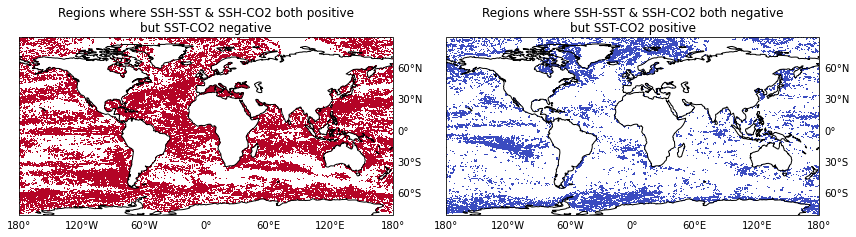

In [59]:
fig, axs= plt.subplots(nrows=1, ncols=2 , figsize=(12,6),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
p=reg.plot.contourf(ax=axs[0], vmin=-1, vmax=1, add_colorbar=False,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
p.axes.coastlines()
axs[0].set_title('Regions where SSH-SST & SSH-CO2 both positive\nbut SST-CO2 negative');

p=reg_r.plot.contourf(ax=axs[1], vmin=-1, vmax=1, add_colorbar=False,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
p.axes.coastlines()
axs[1].set_title('Regions where SSH-SST & SSH-CO2 both negative\nbut SST-CO2 positive');

for i in range(0,2):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False

plt.tight_layout()
plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/correlations/corr_regions/regional_corr_problem.png', bbox_inches="tight", dpi=300);

In [4]:
###wo ist keine problematische Dreiecksbeziehung?
kpd=SSH_SST_DIC_p.where(ds_corr_sst.corr_sst_dic >0)
kpd_r=SSH_SST_DIC_n.where(ds_corr_sst.corr_sst_dic <0)

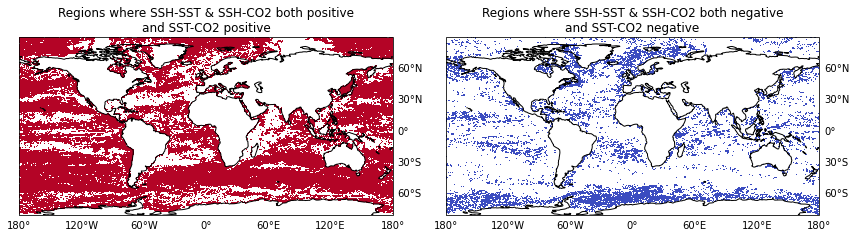

In [20]:
fig, axs= plt.subplots(nrows=1, ncols=2 , figsize=(12,6),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
p=kpd.plot.contourf(ax=axs[0], vmin=-1, vmax=1, add_colorbar=False,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
p.axes.coastlines()
axs[0].set_title('Regions where SSH-SST & SSH-CO2 both positive\nand SST-CO2 positive');

p=kpd_r.plot.contourf(ax=axs[1], vmin=-1, vmax=1, add_colorbar=False,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
p.axes.coastlines()
axs[1].set_title('Regions where SSH-SST & SSH-CO2 both negative\nand SST-CO2 negative');

for i in range(0,2):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False

plt.tight_layout()
plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/correlations/corr_regions/regional_corr_noproblem.png', bbox_inches="tight", dpi=300);

# coarser grid

In [ ]:
def coarsen(ds, var_list, name_list):
    grid=xr.zeros_like(ds.corr_ssh_sst)
    grid=grid[::10,::10]
    for i, item in enumerate(var_list):
        item.name= name_list[i]
    ds=xr.merge(var_list)
    ds_coarse=[]
    for item in list(ds.keys()):
        coarse=ds[item].interp_like(grid)
        ds_coarse.append(coarse)
    ds_coarse=xr.merge(ds_coarse)  
    return ds_coarse

In [37]:
var_list=[SSH_O2_DIC, SSH_SST_O2, SSH_SST_DIC, SST_O2_DIC]
name_list=['SSH_O2_DIC', 'SSH_SST_O2','SSH_SST_DIC','SST_O2_DIC']

In [41]:
ds_coarse=coarsen(ds_corr, var_list, name_list)

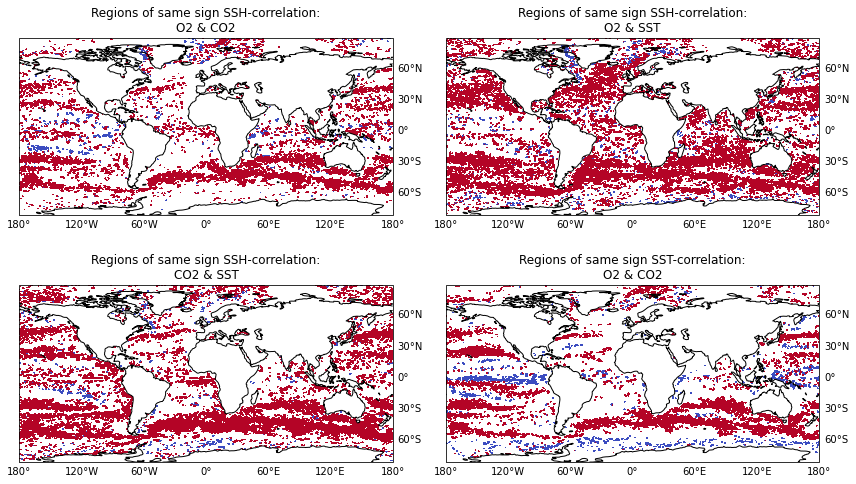

In [42]:
###plotting
fig, axs= plt.subplots(nrows=2, ncols=2 , figsize=(12,7),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()

p=ds_coarse.SSH_O2_DIC.plot.contourf(ax=axs[0], vmin=-1, add_colorbar=False, vmax=1,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
p.axes.coastlines()
axs[0].set_title('Regions of same sign SSH-correlation:\nO2 & CO2')

p=ds_coarse.SSH_SST_O2.plot.contourf(ax=axs[1], vmin=-1, vmax=1, add_colorbar=False,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
p.axes.coastlines()
axs[1].set_title('Regions of same sign SSH-correlation:\nO2 & SST');

p=ds_coarse.SSH_SST_DIC.plot.contourf(ax=axs[2], vmin=-1, vmax=1, add_colorbar=False,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
p.axes.coastlines()
axs[2].set_title('Regions of same sign SSH-correlation:\nCO2 & SST');

p=ds_coarse.SST_O2_DIC.plot.contourf(ax=axs[3], vmin=-1, vmax=1, add_colorbar=False,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
p.axes.coastlines()
axs[3].set_title('Regions of same sign SST-correlation:\nO2 & CO2');

for i in range(0,4):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False

plt.tight_layout()
plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/correlations/corr_regions/regional_corr_coarse.png', bbox_inches="tight", dpi=300);

### problematic regions (code not updated)

In [43]:
regc=reg.interp_like(grid)
regc_r=reg_r.interp_like(grid)

kpdc=kpd.interp_like(grid)
kpdc_r=kpd_r.interp_like(grid)

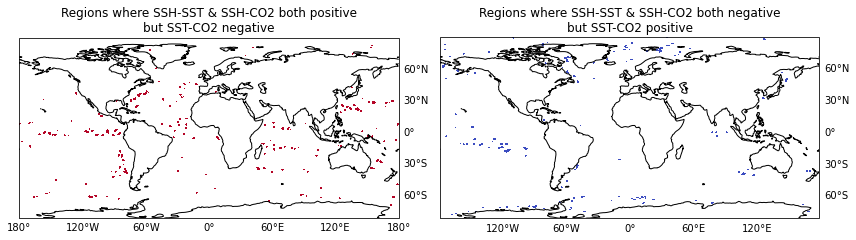

In [44]:
fig, axs= plt.subplots(nrows=1, ncols=2 , figsize=(12,6),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
p=regc.plot.contourf(ax=axs[0], vmin=-1, vmax=1, add_colorbar=False,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
p.axes.coastlines()
axs[0].set_title('Regions where SSH-SST & SSH-CO2 both positive\nbut SST-CO2 negative');

p=regc_r.plot.contourf(ax=axs[1], vmin=-1, vmax=1, add_colorbar=False,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
p.axes.coastlines()
axs[1].set_title('Regions where SSH-SST & SSH-CO2 both negative\nbut SST-CO2 positive');

for i in range(0,2):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False

plt.tight_layout()
plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/correlations/corr_regions/regional_corr_problem_coarse.png', bbox_inches="tight", dpi=300);

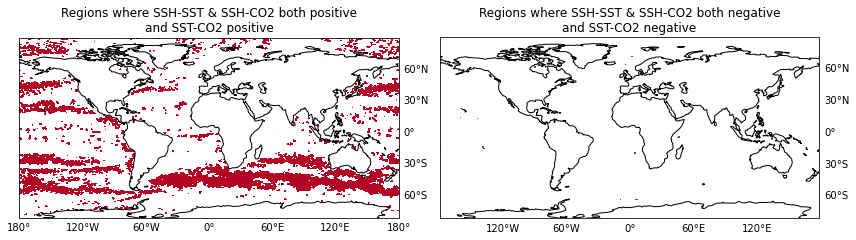

In [45]:
fig, axs= plt.subplots(nrows=1, ncols=2 , figsize=(12,6),subplot_kw={'projection': ccrs.PlateCarree()})
axs=axs.flatten()
p=kpdc.plot.contourf(ax=axs[0], vmin=-1, vmax=1, add_colorbar=False,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
p.axes.coastlines()
axs[0].set_title('Regions where SSH-SST & SSH-CO2 both positive\nand SST-CO2 positive');

p=kpdc_r.plot.contourf(ax=axs[1], vmin=-1, vmax=1, add_colorbar=False,transform = ccrs.PlateCarree(), cmap='coolwarm',levels=np.linspace(-1,1,3))
p.axes.coastlines()
axs[1].set_title('Regions where SSH-SST & SSH-CO2 both negative\nand SST-CO2 negative');

for i in range(0,2):
    gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False

plt.tight_layout()
plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/correlations/corr_regions/regional_corr_noproblem_coarse.png', bbox_inches="tight", dpi=300);